# Propagation de Labels

Le machine learning supervisé, par exemple la classification comme on l'a vue dans le TP7, repose sur la disponibilité de données avec des labels.
L'objectif de l'apprentissage était alors d'apprendre à prédire les labels pour des nouveaux points.

Mais avoir des données avec des labels de bonne qualité demande un gros travail de labellisation, souvent très laborieux et pénible à réaliser. (Et souvent réalisé par des travailleur-euses extrêmement précaires, via des plateformes comme Amazon Mechanical Turk.)
Comme les algorithmes de machine learning peuvent demander une quantité importante de données pour donner de bons résultats, il peut s'avérer utile de réussir à obtenir automatiquement les labels pour l'ensemble des données, à partir d'un nombre limité d'exemples.

Ces labels peuvent être obtenus en exploitant une certaine notion de similarité entre les points, en supposant que deux points proches auront souvent le même label.
Pour cela, on peut utiliser les mêmes techniques que celles que l'on a utilisées au TP précédent pour le machine learning non supervisé.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

# datasets
from sklearn.datasets import make_circles, make_moons, make_blobs

# arbres de décision
from sklearn.tree import DecisionTreeClassifier

# graphe des plus proches voisins
from sklearn.neighbors import kneighbors_graph

## Jeux de données

Commençons par générer quelques jeux de données, qui vont nous permettre d'étudier le comportement de notre algorithme de propagation de labels dans plusieurs situations.

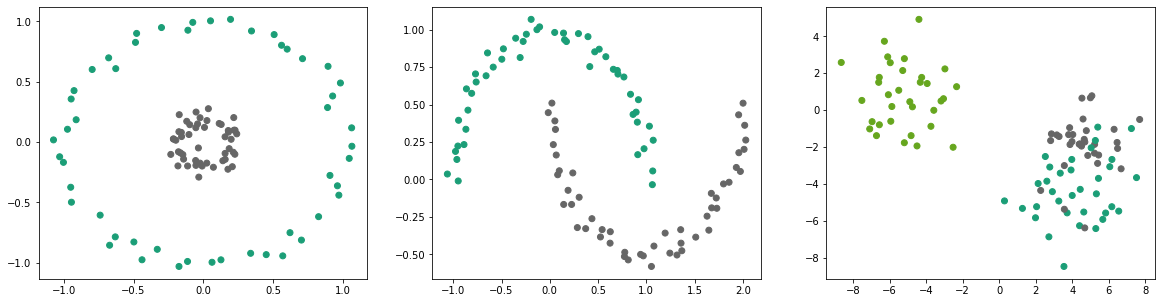

In [2]:
X_circle, y_circle = make_circles(noise=0.05, factor=0.2, shuffle=True, random_state=123)
X_moons, y_moons = make_moons(noise=0.05, shuffle=True, random_state=123)
X_noisy, y_noisy = make_blobs(cluster_std=1.5, random_state=123)

y_circle, y_moons, y_noisy = y_circle.astype("float32"), y_moons.astype("float32"), y_noisy.astype("float32")

fig, ax = plt.subplots(1, 3, figsize=(20,5))

ax[0].scatter(X_circle[:,0], X_circle[:,1], c=y_circle, cmap="Dark2")
ax[1].scatter(X_moons[:,0], X_moons[:,1], c=y_moons, cmap="Dark2")
ax[2].scatter(X_noisy[:,0], X_noisy[:,1], c=y_noisy, cmap="Dark2")

In [3]:
def afficher_frontiere(clf, X, y, trained_on=None, ax=None):
    """
    Affiche les frontières de décision du classifieur `clf`.
    
    L'argument `trained_on`, s'il est donné, doit être sous la forme d'une
    liste d'entiers, correspondant aux indices des éléments du dataset qui
    ont été utilisés pour entraîner le modèle, pour les afficher en couleur
    dans le plot final.
    
    L'argument `ax` permet d'afficher le résultat sur des axes, sinon une
    nouvelle figure est générée.
    """
    h=0.01

    if ax is None:
        _, ax = plt.subplots()
        
    if trained_on is None:
        ax.scatter(X[:,0], X[:,1], c=y, cmap="Dark2")
    else:
        ax.scatter(X[:, 0], X[:, 1], c="lightgrey")
        ax.scatter(X[trained_on, 0], X[trained_on, 1], c=y[trained_on], cmap="Dark2")
    pb=clf.predict(X)
    

    # grille
    x_min, x_max = X[:, 0].min() - 0.2, X[:, 0].max() + 0.2
    y_min, y_max = X[:, 1].min() - 0.2, X[:, 1].max() + 0.2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # labels prédits pour chacun des points de la grille
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # affichage du résultat
    Z = Z.reshape(xx.shape)
    ax.imshow(Z, interpolation="nearest",
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap="Dark2", aspect="auto", origin="lower", alpha=0.6)
    
    ax.axis("off")

**Question 1.** Entrainez des `DecisionTreeClassifier` sur chacun de ces trois jeux de données, et affichez les frontières de décision des modèles appris avec la fonction `afficher_frontiere` donnée ci-dessus.

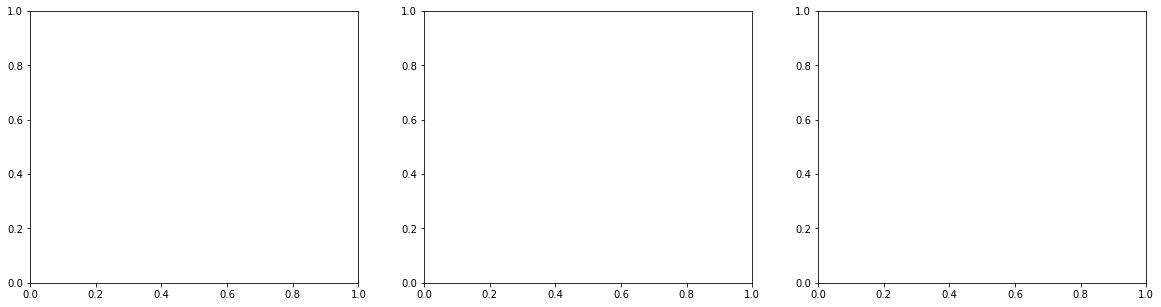

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))

## Graphe des k plus proches voisins

Les deux fonctions suivantes permettent de générer le graphe des k plus proches voisins d'un jeu de donnée, et d'afficher ce graphe.

In [5]:
def graphe_voisins(X, nb_voisins=10):
    return kneighbors_graph(X, nb_voisins, include_self=True).todense()
    
def afficher_graphe_voisins(X, graphe, y=None, ax=None):
    segs = []
    for i, x in enumerate(X):
        for j, z in enumerate(X):
            if graphe[i,j] > 0:
                segs.append((x, z))

    line_segments = LineCollection(segs, linewidths=2, linestyle='solid', color="pink", zorder = -1)

    if ax is None:
        _, ax = plt.subplots()
    
    ax.set_axis_off()
    ax.add_collection(line_segments)
    
    if y is None:
        ax.scatter(X[:,0], X[:, 1], color="grey")
    else:
        ax.scatter(X[:,0], X[:, 1], color="#AAAAAA")
        ax.scatter(X[:,0], X[:, 1], c=y, cmap="Dark2")

Par exemple, sur le jeu de données `X_moons`, on obtient :

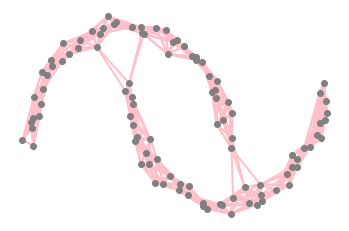

In [6]:
mat = graphe_voisins(X_moons, nb_voisins=10)
afficher_graphe_voisins(X_moons, mat)

**Question 2.** Affichez le graphe des plus proches voisins sur le dataset `X_moons`. Faites varier le nombre de voisins dans le graphe (argument `nb_voisins` de `graphe_voisins`).

Que se passe-t-il quand le nombre de voisins est trop petit (par exemple quand il vaut 1 ou 2) ? Et quand il est trop grand (plus de 30 par exemple) ?

*Réponse :*

## Propagation de labels

Maintenant que nous avons une façon de mesurer la proximité entre des points, on peut essayer de propager les labels dans le graphe.

On procède ainsi :
* au début, on ne connaît les labels que de quelques points ;
* ensuite, on boucle :
    * pour chacun des points, on regarde tous ses voisins dans le graphe, et on distingue deux cas :
        * si aucun de ses voisins n'a de label, auquel cas on ne donne pas de label au point ;
        * sinon, on prend le label qui apparaît le plus dans ses voisins.
        
C'est donc un algorithme itératif, qui attribue itérativement des nouveaux labels aux points.
On l'appelle **propagation de labels**, car les labels se propagent à leurs voisins, jusqu'à ce qu'une situation stable soit atteinte.

Cet algorithme est implémenté dans la fonction suivante :

In [ ]:
def propager_labels(X, y, graphe, afficher=False):
    adj = [np.where(graphe[i,:] == 1)[1] for i in range(graphe.shape[0])]
    labels = y.copy()
    old_labels = -labels
    
    while not ((labels == old_labels) | (np.isnan(labels) & np.isnan(old_labels))).all():
    
        if afficher:
            afficher_graphe_voisins(X, graphe, y=labels)
    
        old_labels = labels.copy()
        colors = labels[adj]
        colors_nonan = [np.unique(c[~(np.isnan(c))], return_counts=True) for c in colors]
        labels = [c[0][np.argmax(c[1])] if len(c[0]) > 0 else labels[i] for i,c in enumerate(colors_nonan)]
        labels = np.array(labels)
        
    afficher_graphe_voisins(X, graphe, y=labels)
    
    return labels

Pour représenter les valeurs de `y` pour lesquelles on ne connaît pas le label, on utilise `np.nan`, il suffit donc de mettre la valeur `np.nan` à la place de tous les labels qu'on ne connaît pas.

Ainsi, on peut par exemple garder seulement les labels des deux premiers éléments de `X_moons` (qui, par chance, ont deux labels différents).
Regardons ce qui se passe :

In [ ]:
y2 = y_moons.copy()
y2[2:] = np.nan
propager_labels(X_moons, y2, graphe_voisins(X_moons), afficher=True);

On retrouve bien les labels que l'on voudrait trouver.

**Question 3.** Lancez la fonction en utilisant les graphes de la question 2, avec soit très peu soit beaucoup de voisins, et sur les mêmes labels que dans la cellule de code précédente. (C'est-à-dire la variable `y2` où seuls les deux premiers labels sont gradés.) Que constatez-vous dans chacun des cas ?

*Réponse :*

**Question 4.a.** Lancez l'algorithme de la même façon sur les jeux de données `X_noisy` et `X_circle`, en gardant à chaque fois uniquement les $5$ premiers labels des datasets.
Pour ces deux datasets, cherchez le nombre de voisins dans le graphe des plus proches voisins qui fonctionne bien.

In [ ]:
# garder seulement les 5 premiers labels pour le dataset X_circle, y_circle


In [ ]:
# garder seulement les 5 premiers labels pour le dataset X_noisy, y_noisy


**Question 4.b.** Que dire des labels obtenus par notre algorithme sur les donnes `X_noisy` ? Que dire des labels obtenus dans une situation où les mesures des points de X sont très imprécises ?

*Réponse :*

## Entraînement d'arbres de décision

Le but de la propagation de labels est de pouvoir entraîner des modèles plus pertinents, malgré le manque de données avec des labels.

Essayons donc de voir ce que l'on a gagné.
Pour cela, on peut reprendre le code de la question 1, pour entraîner des arbres de décision en n'utilisant cette fois plus que les 5 premiers points de chacun de nos datasets.

On obtient les classifieurs suivants, les points dont les labels ont été utilisés sont affichés en couleur, et les autres en gris clair.

In [ ]:
clf = DecisionTreeClassifier()
fig, ax = plt.subplots(1, 3, figsize=(20,5))

clf.fit(X_circle[:5,:], y_circle[:5])
afficher_frontiere(clf, X_circle, y_circle, trained_on=np.arange(5), ax=ax[0])

clf.fit(X_moons[:5,:], y_moons[:5])
afficher_frontiere(clf, X_moons, y_moons, trained_on=np.arange(5), ax=ax[1])

clf.fit(X_noisy[:5,:], y_noisy[:5])
afficher_frontiere(clf, X_noisy, y_noisy, trained_on=np.arange(5), ax=ax[2])

**Question 5.** Reprenez le code de la question 4.a., en utilisant `propager_labels` pour calculer les labels obtenus par propagation. Entraînez à nouveau des arbres de décision et commentez les résultats obtenus.